In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import plotly.graph_objects as go
import os
import sys  

sys.path.insert(0, '../')

pd.set_option('display.max_columns', None)

from soundings.preprocessing import dataloader as dl
from soundings.deep_learning import mlutilities as ml
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot
from soundings.deep_learning import tf_neuralnetwork as nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
VOL = '/mnt/data1/stock/mlsoundings/results'

In [3]:
X = np.linspace(0, 5, 20)
T = np.sin(X)

In [24]:
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression().fit(rap[0,:,-1], raob[0,:,1])
# iso_reg.predict(rap[0,:,1])

In [11]:
iso_reg

IsotonicRegression()

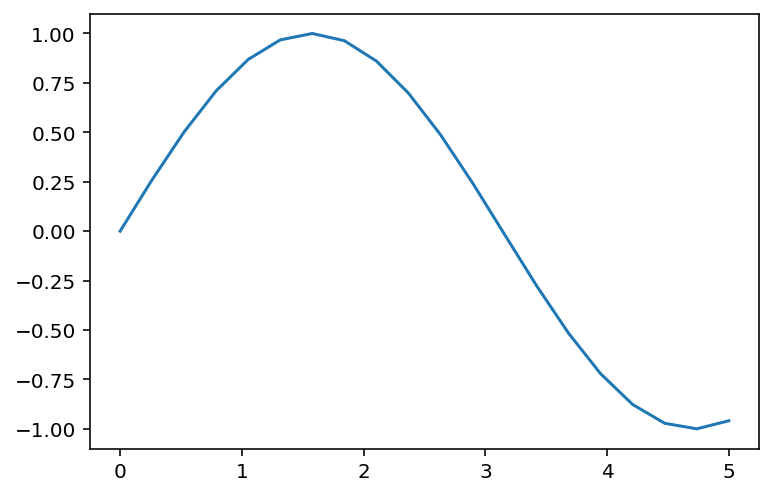

In [26]:
plt.plot(X, T)

## Baseline Metrics

In [3]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?
container.close()

train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

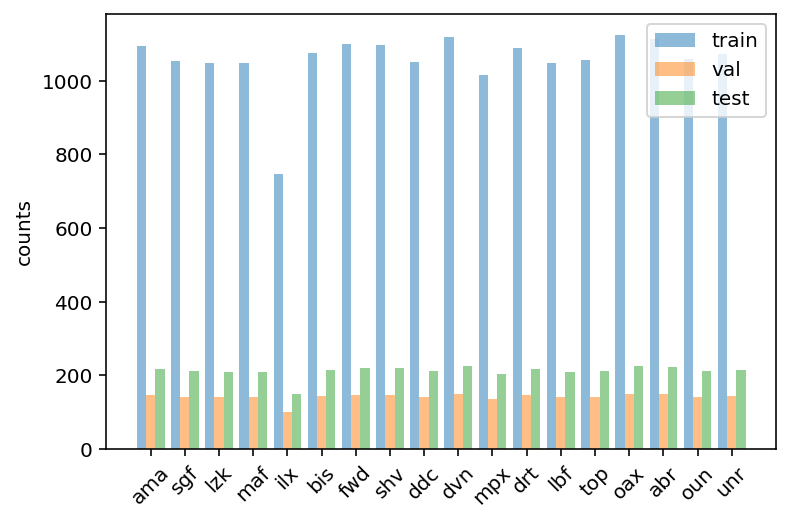

In [4]:
locations = {'bis', 'abr', 'unr', 'lbf', 'oax', 'top',
             'ddc', 'oun', 'ama', 'fwd', 'maf', 'drt',
             'lzk', 'sgf', 'shv', 'dvn', 'ilx', 'mpx'} # 'sgp'
ind = np.arange(len(locations))
width = 0.27 # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

_, counts = np.unique([f.split('_')[0] for f in FILEtrain], return_counts=True)
rects1 = ax.bar(ind, counts, width, alpha=0.5)
_, counts = np.unique([f.split('_')[0] for f in FILEval], return_counts=True)
rects2 = ax.bar(ind+width, counts, width, alpha=0.5)
_, counts = np.unique([f.split('_')[0] for f in FILEtest], return_counts=True)
rects3 = ax.bar(ind+width*2, counts, width, alpha=0.5)

ax.set_ylabel('counts')
ax.set_xticks(ind+width)
ax.set_xticklabels(locations, rotation=45)
ax.legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

In [111]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [51]:
def min_max(df):
    min_i = np.inf
    min_v = np.inf
    max_i = 0
    max_v = 0
    for i, row in df.iterrows():
        train_rmse = np.asarray(literal_eval(row[f'root_mean_squared_error']))
        if train_rmse.min() < min_v:
            min_v = train_rmse.min()
            min_i = i
        if train_rmse.max() > max_v:
            max_v = train_rmse.max()
            max_i = i  

        plt.plot(train_rmse)
        plt.plot(np.asarray(literal_eval(row[f'val_root_mean_squared_error'])),'--')

    return min_i, min_v, max_i, max_v

# Linear

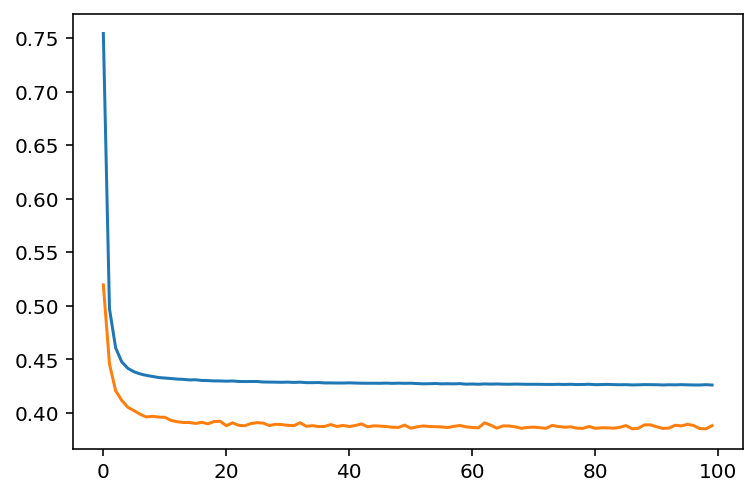

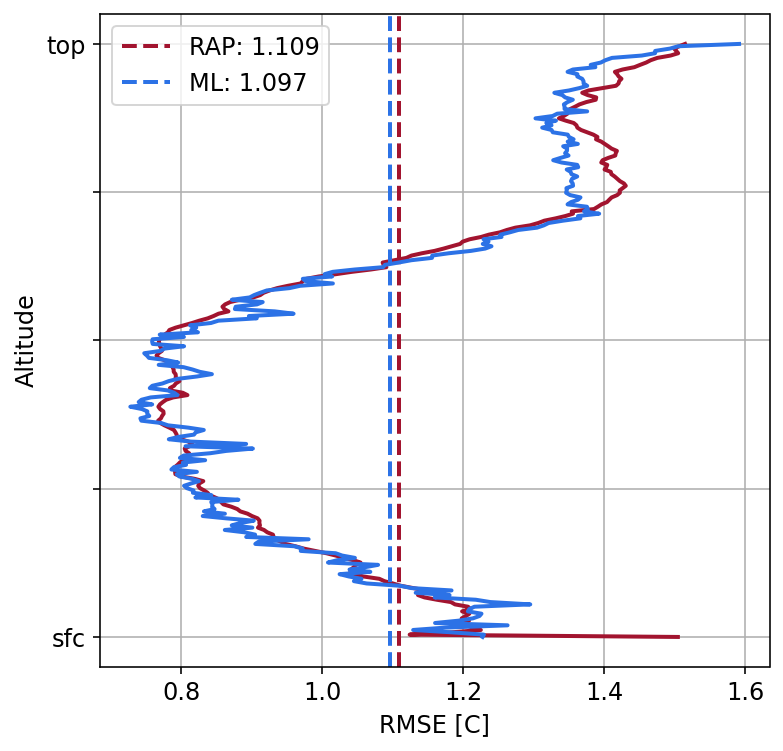

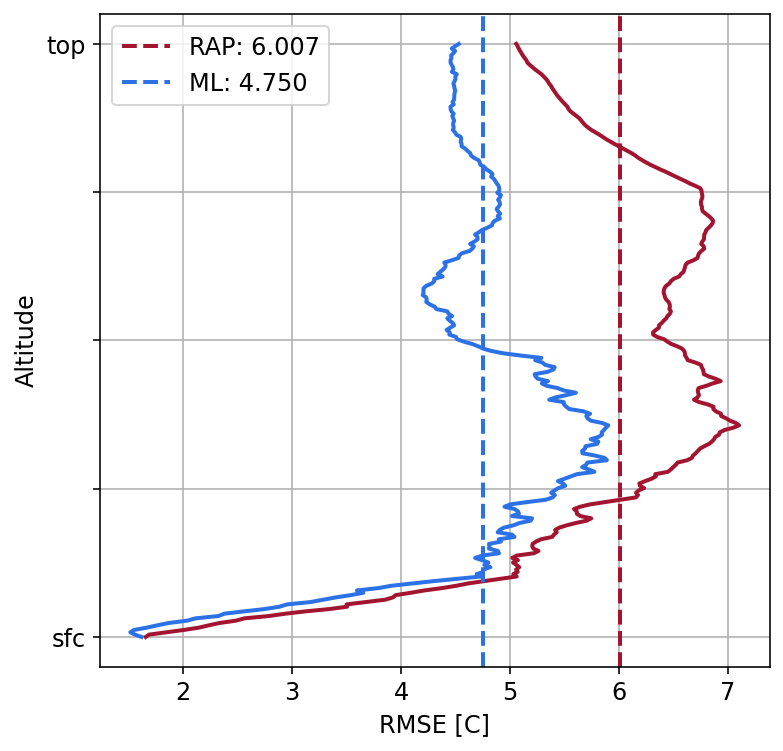

In [52]:
df = pd.read_csv(os.path.join(VOL, 'alley_linear_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [53]:
df.sort_values(['ml_temperature_test_mean_rmse'])[:5]

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_network_inputs,hiddens,n_network_outputs,optim,lr,activ,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
310,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[0],512,adam,0.0001,None,MAE,100,128,False,False,"[0.5384315848350525, 0.33815300464630127, 0.29...","[0.7541673183441162, 0.497248113155365, 0.4608...","[0.568768322467804, 0.24725566804409027, 0.212...","[0.5384315848350525, 0.33815300464630127, 0.29...","[0.37454554438591003, 0.3049970269203186, 0.27...","[0.5195618271827698, 0.44576188921928406, 0.42...","[0.26994451880455017, 0.19870366156101227, 0.1...","[0.37454554438591003, 0.3049970269203186, 0.27...","[0.8943959621621206, 0.9007917651171699, 0.961...",1.066225,"[0.8943959621621206, 0.9007917651171699, 0.961...",1.026329,"[1.0938166535958098, 1.3003595783372999, 1.405...",4.927718,"[1.0938166535958098, 1.3003595783372999, 1.405...",3.107655,"[0.9262176305678401, 0.9186400424341179, 0.918...",0.980041,"[0.9262176305678401, 0.9186400424341179, 0.918...",0.975819,"[1.1949759788840757, 1.1964436893750001, 1.293...",4.699065,"[1.1949759788840757, 1.1964436893750001, 1.293...",3.211968,"[1.2273282842467073, 1.229276109727186, 1.1826...",1.096661,"[1.2273282842467073, 1.229276109727186, 1.1826...",1.185546,"[1.615812190091477, 1.557970972330886, 1.51448...",4.750354,"[1.615812190091477, 1.557970972330886, 1.51448...",2.870993
214,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[0],512,adam,0.0001,None,MAE,100,128,False,False,"[0.5455870628356934, 0.34122592210769653, 0.30...","[0.766140341758728, 0.5053848028182983, 0.4691...","[0.5869710445404053, 0.2554137706756592, 0.220...","[0.5455870628356934, 0.34122592210769653, 0.30...","[0.37723496556282043, 0.30422478914260864, 0.2...","[0.5255159735679626, 0.4502125382423401, 0.427...","[0.27616703510284424, 0.20269131660461426, 0.1...","[0.37723496556282043, 0.30422478914260864, 0.2...","[0.870917137211884, 0.8880040815650244, 0.9529...",1.062495,"[0.870917137211884, 0.8880040815650244, 0.9529...",1.032684,"[1.0800442216121429, 1.3080679499653143, 1.410...",5.091276,"[1.0800442216121429, 1.3080679499653143, 1.410...",3.101258,"[0.9332778425263499, 0.8934031100929197, 0.913...",0.972696,"[0.9332778425263499, 0.8934031100929197, 0.913...",0.988025,"[1.256332754158335, 1.1778157066402735, 1.2801...",4.815618,"[1.256332754158335, 1.1778157066402735, 1.2801...",3.206483,"[1.2502792344340814, 1.198245459492034, 1.1425...",1.096874,"[1.2502792344340814, 1.198245459492034, 1.1425...",1.215851,"[1.3531946318380925, 1.6143572604475565, 1.553...",4.920945,"[1.3531946318380925, 1.6143572604475565, 1.553...",2.869417
213,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[0],512,adam,0.0001,None,MAE,100,64,False,False,"[0.4526112973690033, 0.29860445857048035, 0.27...","[0.6563752293586731, 0.4672042727470398, 0.451...","[0.43082842230796814, 0.21827982366085052, 0.2...","[0.4526112973690033, 0.29860445857048035, 0.27...","[0.3153027594089508, 0.27295681834220886, 0.25...","[0.4605417549610138, 0.4219203293323517, 0.411...","[0.21209870278835297, 0.1780167669057846, 0.16...","[0.3153027594089508, 0.272

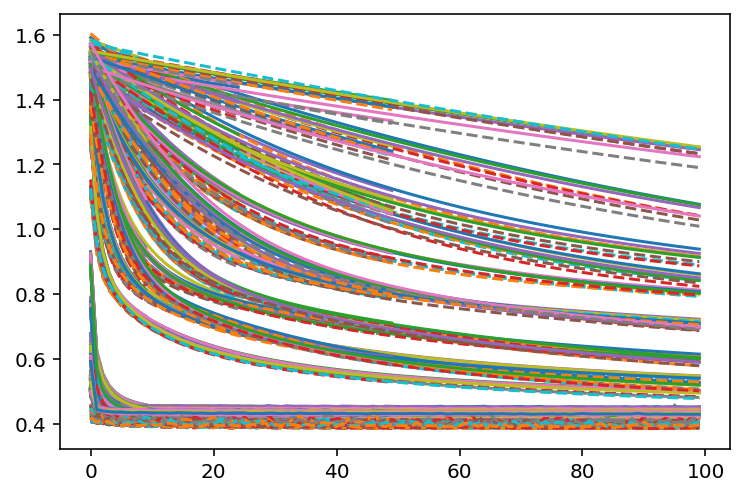

In [54]:
min_i, min_v, max_i, max_v = min_max(df)

# Fully Connected

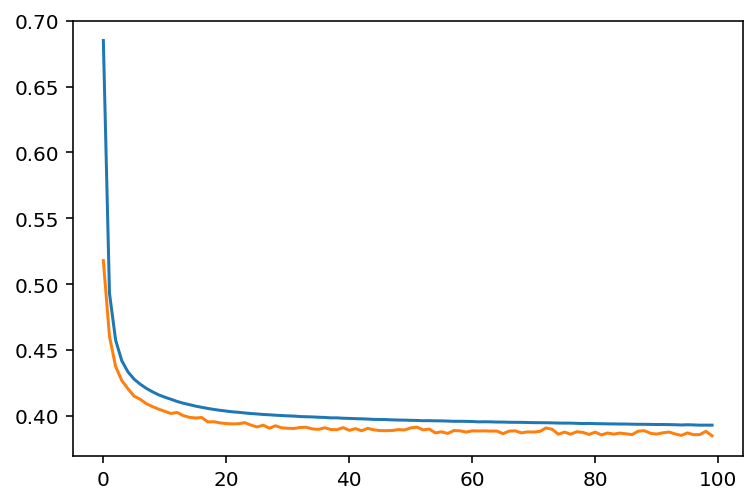

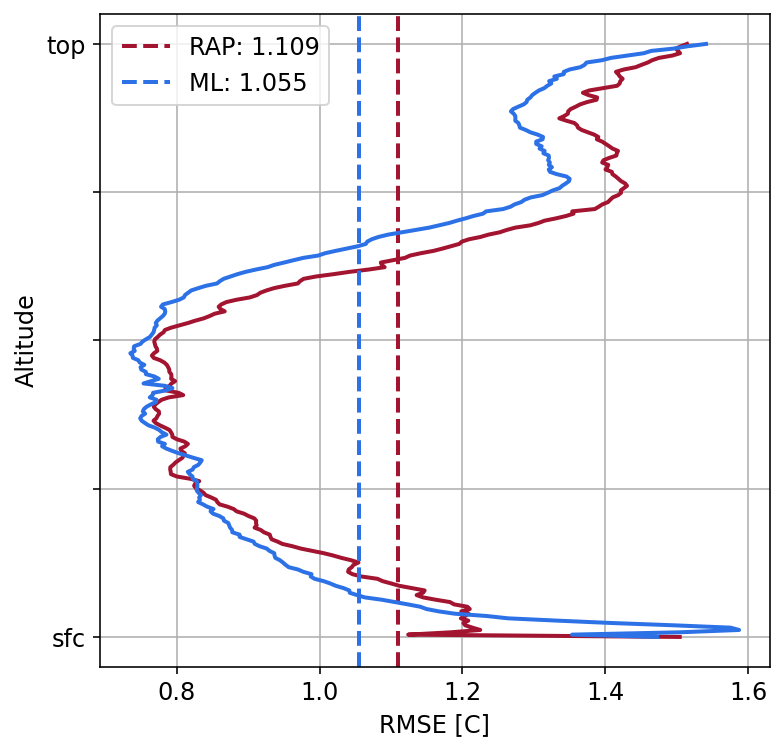

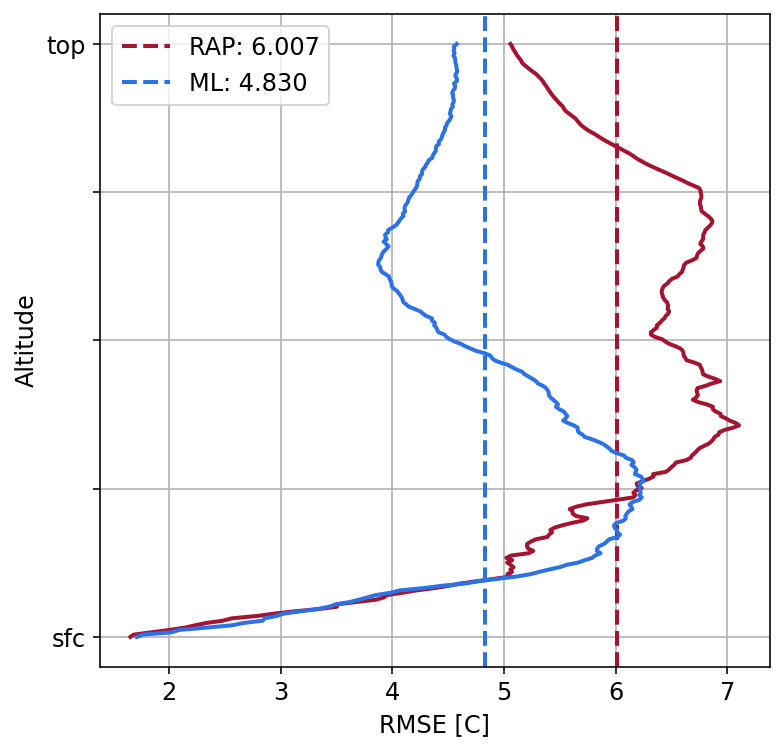

In [55]:
df = pd.read_csv(os.path.join(VOL, 'alley_fully_connected_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [56]:
df.sort_values(['ml_temperature_test_mean_rmse'])[:5]

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_network_inputs,hiddens,n_network_outputs,optim,lr,activ,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
126,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[64],512,adam,0.0001,relu,MAE,100,128,False,False,"[0.4934042692184448, 0.3312535881996155, 0.295...","[0.685124397277832, 0.49297788739204407, 0.457...","[0.4693954288959503, 0.2430272102355957, 0.209...","[0.4934042692184448, 0.3312535881996155, 0.295...","[0.3579365015029907, 0.3040143549442291, 0.281...","[0.5178511142730713, 0.4602089524269104, 0.437...","[0.2681697607040405, 0.21179227530956268, 0.19...","[0.3579365015029907, 0.3040143549442291, 0.281...","[1.3486848124129374, 1.0791583418013586, 1.148...",1.114438,"[1.3486848124129374, 1.0791583418013586, 1.148...",1.075819,"[1.4182571180563492, 1.493236130330106, 1.5960...",4.779284,"[1.4182571180563492, 1.493236130330106, 1.5960...",3.421152,"[1.2741794616596895, 1.122694639532622, 1.1708...",1.051433,"[1.2741794616596895, 1.122694639532622, 1.1708...",1.085166,"[1.5647304777230704, 1.5350221403799407, 1.662...",4.835631,"[1.5647304777230704, 1.5350221403799407, 1.662...",3.390414,"[1.4726413768022784, 1.3534256964611575, 1.504...",1.055313,"[1.4726413768022784, 1.3534256964611575, 1.504...",1.233140,"[1.7140471400963193, 1.7684637567478887, 2.026...",4.829755,"[1.7140471400963193, 1.7684637567478887, 2.026...",3.369792
174,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[64],512,adam,0.0001,relu,MAE,100,128,False,False,"[0.4912017285823822, 0.32886770367622375, 0.29...","[0.6835126280784607, 0.48864468932151794, 0.45...","[0.4671894907951355, 0.2387736290693283, 0.203...","[0.4912017285823822, 0.32886770367622375, 0.29...","[0.3562816083431244, 0.29858797788619995, 0.27...","[0.5136996507644653, 0.4513487219810486, 0.429...","[0.26388734579086304, 0.20371568202972412, 0.1...","[0.3562816083431244, 0.29858797788619995, 0.27...","[1.3052386717689426, 1.1213862852933238, 1.179...",1.118914,"[1.3052386717689426, 1.1213862852933238, 1.179...",1.089736,"[1.3687512377080235, 1.4759797521785374, 1.585...",4.654249,"[1.3687512377080235, 1.4759797521785374, 1.585...",3.420518,"[1.258951248128888, 1.1505402201634398, 1.1937...",1.064207,"[1.258951248128888, 1.1505402201634398, 1.1937...",1.118072,"[1.4688311562071612, 1.4977860577884823, 1.657...",4.724150,"[1.4688311562071612, 1.4977860577884823, 1.657...",3.399673,"[1.355836145064035, 1.3776894888612232, 1.5419...",1.062862,"[1.355836145064035, 1.3776894888612232, 1.5419...",1.250122,"[1.7430212547633894, 1.7649899183250146, 2.028...",4.713086,"[1.7430212547633894, 1.7649899183250146, 2.028...",3.375022
122,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[64],512,adam,0.0001,tanh,MAE,100,128,False,False,"[0.5100987553596497, 0.33771657943725586, 0.29...","[0.6902581453323364, 0.4976118505001068, 0.456...","[0.47645634412765503, 0.24761754274368286, 0.2...","[0.5100987553596497, 0.33771657943725586, 0.29...","[0.3776352107524872, 0.30688342452049255, 0.28...","[0.5313875079154968, 0.4613611400127411, 0.437...","[0.28237268328666687, 0.21285410225391388, 0.1...","[0.3776352107524872, 0

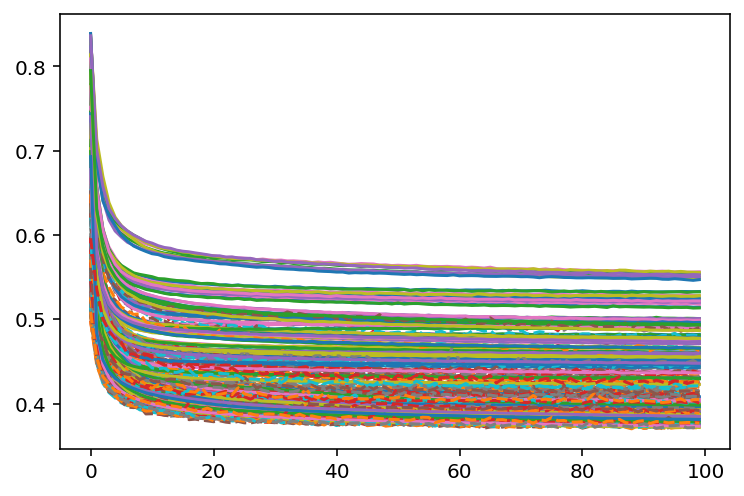

In [57]:
min_i, min_v, max_i, max_v = min_max(df)

# Convolutional

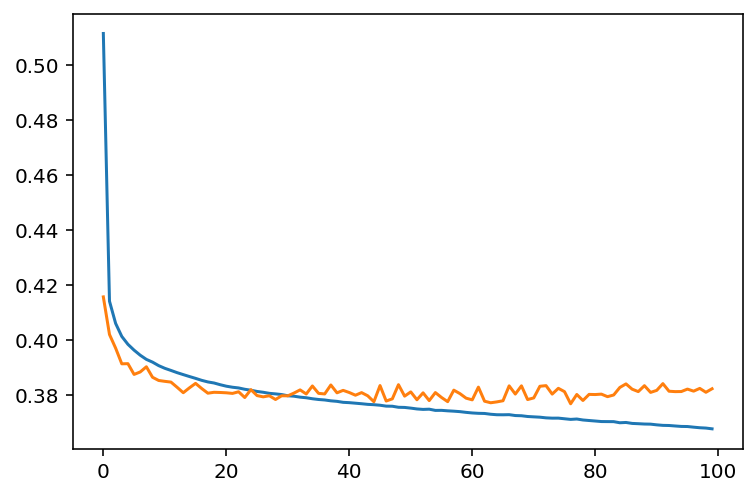

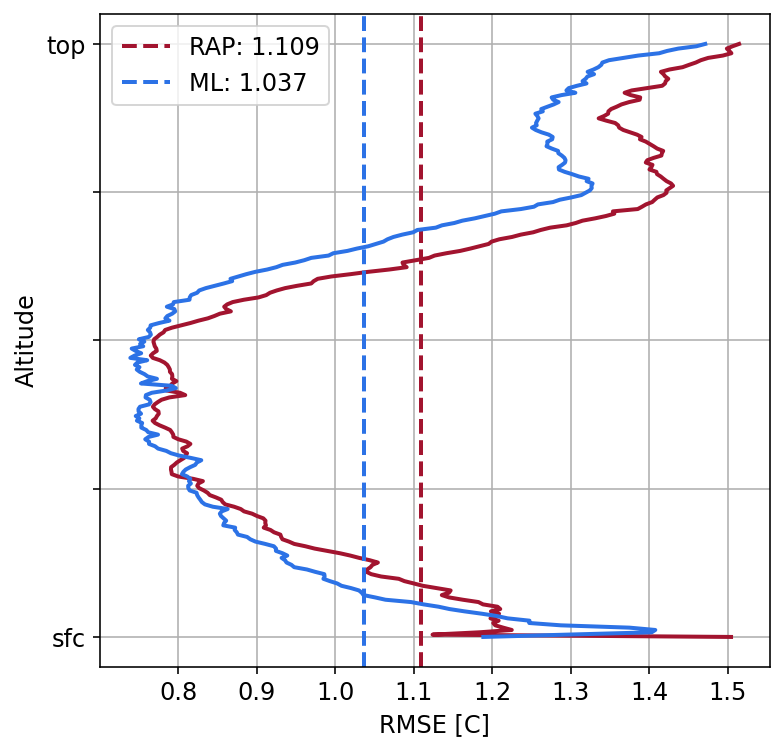

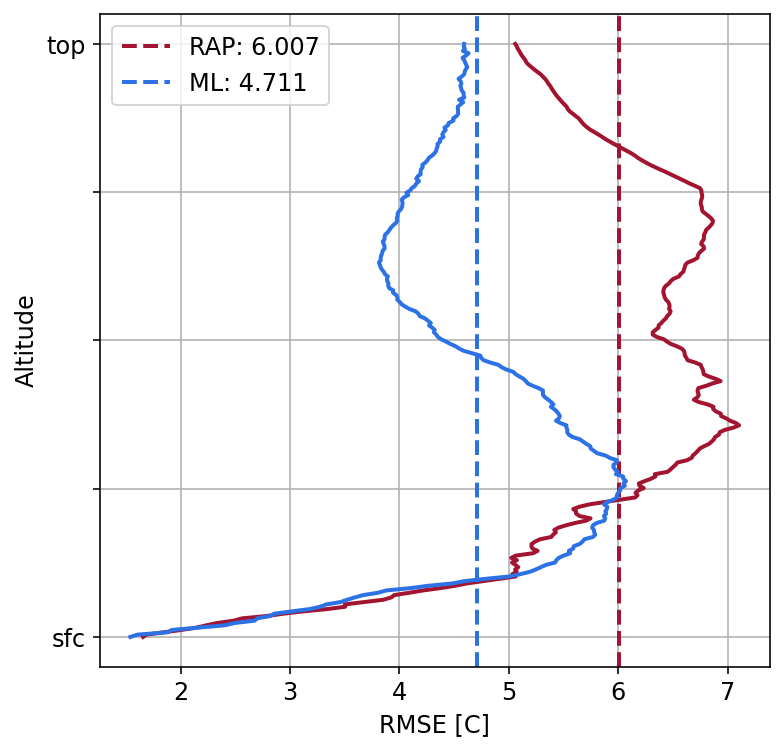

In [58]:
df = pd.read_csv(os.path.join(VOL, 'alley_multi_cnn_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [59]:
sorted_df = df.sort_values(['ml_temperature_test_mean_rmse'])
sorted_df.head()

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
52,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],"(256, 4)","(3, 3, 3)",[],512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.3333439230918884, 0.2500196695327759, 0.241...","[0.5114827156066895, 0.4141363501548767, 0.406...","[0.2616145610809326, 0.17150892317295074, 0.16...","[0.3333439230918884, 0.2500196695327759, 0.241...","[0.2574329972267151, 0.2473011314868927, 0.239...","[0.4156915247440338, 0.4020220637321472, 0.397...","[0.17279945313930511, 0.16162174940109253, 0.1...","[0.2574329972267151, 0.2473011314868927, 0.239...","[1.0232496661048107, 0.9911975247049769, 1.033...",1.073705,"[1.0232496661048107, 0.9911975247049769, 1.033...",0.967400,"[1.1871945903452743, 1.3575554692367702, 1.464...",4.524464,"[1.1871945903452743, 1.3575554692367702, 1.464...",3.186743,"[1.120097372118839, 1.052837630974231, 1.06851...",1.031497,"[1.120097372118839, 1.052837630974231, 1.06851...",1.013371,"[1.382755460030545, 1.4483476335346892, 1.5800...",4.738195,"[1.382755460030545, 1.4483476335346892, 1.5800...",3.213262,"[1.1886814397549854, 1.293640634593439, 1.4031...",1.036667,"[1.1886814397549854, 1.293640634593439, 1.4031...",1.164859,"[1.539709938663092, 1.6058249272258605, 1.8825...",4.710809,"[1.539709938663092, 1.6058249272258605, 1.8825...",3.205394
68,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)",[],512,"[16, 32, 64, 128, 128]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.36440008878707886, 0.2574280798435211, 0.24...","[0.5465730428695679, 0.41803857684135437, 0.40...","[0.2987420856952667, 0.1747562438249588, 0.167...","[0.36440008878707886, 0.2574280798435211, 0.24...","[0.2663699984550476, 0.2485267072916031, 0.244...","[0.4185488224029541, 0.400831013917923, 0.3983...","[0.17518311738967896, 0.16066549718379974, 0.1...","[0.2663699984550476, 0.2485267072916031, 0.244...","[1.0329489324085555, 1.0322728263078003, 1.101...",1.089694,"[1.0329489324085555, 1.0322728263078003, 1.101...",1.005307,"[1.206007095058442, 1.4108720320323227, 1.5418...",4.485113,"[1.206007095058442, 1.4108720320323227, 1.5418...",3.257196,"[1.1290671568329267, 1.0913833362035898, 1.118...",1.039979,"[1.1290671568329267, 1.0913833362035898, 1.118...",1.039056,"[1.3675836232877523, 1.4706654836582826, 1.628...",4.612480,"[1.3675836232877523, 1.4706654836582826, 1.628...",3.228331,"[1.1946459981587658, 1.3491338403715658, 1.476...",1.038873,"[1.1946459981587658, 1.3491338403715658, 1.476...",1.169139,"[1.5319817894615226, 1.6247766873672362, 1.890...",4.599223,"[1.5319817894615226, 1.6247766873672362, 1.890...",3.243861
70,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)",[],512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.32851487398147583, 0.24769161641597748, 0.2...","[0.5071620345115662, 0.4093931317329407, 0.401...","[0.25721332

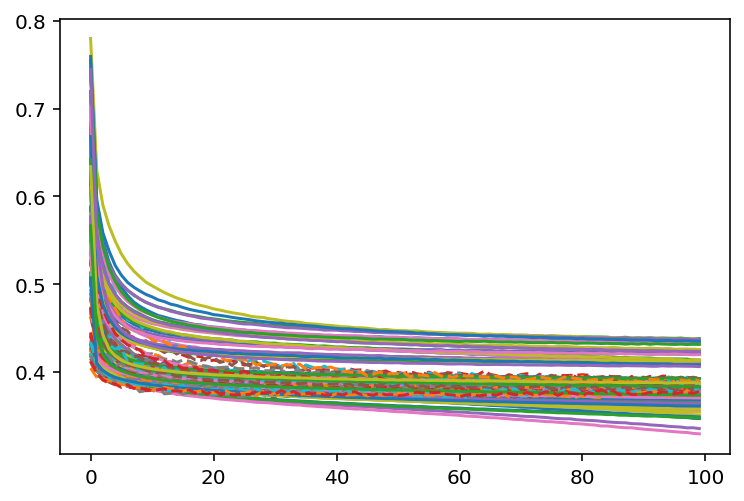

In [60]:
min_i, min_v, max_i, max_v = min_max(df)

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
58,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[512, 256]",512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.3614846169948578, 0.2585483193397522, 0.245...","[0.5427217483520508, 0.41674473881721497, 0.40...","[0.29454687237739563, 0.17367619276046753, 0.1...","[0.3614846169948578, 0.2585483193397522, 0.245...","[0.2672538161277771, 0.2512344419956207, 0.241...","[0.418175607919693, 0.4053471088409424, 0.3904...","[0.17487084865570068, 0.16430626809597015, 0.1...","[0.2672538161277771, 0.2512344419956207, 0.241...","[1.0590920513499826, 1.015223422450158, 1.0688...",1.069911,"[1.0590920513499826, 1.015223422450158, 1.0688...",0.987656,"[1.2108014080458758, 1.377700055883828, 1.4790...",4.088064,"[1.2108014080458758, 1.377700055883828, 1.4790...",3.179957,"[1.1925086731476826, 1.103203275114559, 1.1105...",1.036662,"[1.1925086731476826, 1.103203275114559, 1.1105...",1.037555,"[1.379692256925536, 1.4332177186471402, 1.5587...",4.522909,"[1.379692256925536, 1.4332177186471402, 1.5587...",3.202499,"[1.2327280878526992, 1.3126920193133431, 1.401...",1.058617,"[1.2327280878526992, 1.3126920193133431, 1.401...",1.188546,"[1.5184267938406495, 1.6086262171049412, 1.871...",4.522030,"[1.5184267938406495, 1.6086262171049412, 1.871...",3.206723
59,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[512, 256]",512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,True,"[0.5137460231781006, 0.38709786534309387, 0.35...","[0.6932787895202637, 0.5403785705566406, 0.504...","[0.48063546419143677, 0.29200902581214905, 0.2...","[0.5137460231781006, 0.38709786534309387, 0.35...","[0.3557327091693878, 0.3124712109565735, 0.287...","[0.5126138925552368, 0.4564325511455536, 0.433...","[0.26277297735214233, 0.2083306759595871, 0.18...","[0.3557327091693878, 0.3124712109565735, 0.287...","[3.1796852654603325, 2.391644811637852, 2.1204...",1.280537,"[3.1796852654603325, 2.391644811637852, 2.1204...",1.696588,"[2.3417213218229795, 2.329839814274119, 2.3451...",4.603175,"[2.3417213218229795, 2.329839814274119, 2.3451...",3.900029,"[2.9424028088762504, 2.311208414123001, 2.0461...",1.284901,"[2.9424028088762504, 2.311208414123001, 2.0461...",1.656466,"[2.2569287907538205, 2.269241924129646, 2.3387...",4.876856,"[2.2569287907538205, 2.269241924129646, 2.3387...",3.917912,"[3.2682959643578937, 2.6575429018801584, 2.486...",1.321462,"[3.2682959643578937, 2.6575429018801584, 2.486...",1.920344,"[2.846721487272308, 2.638347113383979, 2.73458...",4.779603,"[2.846721487272308, 2.638347113383979, 2.73458...",3.780131


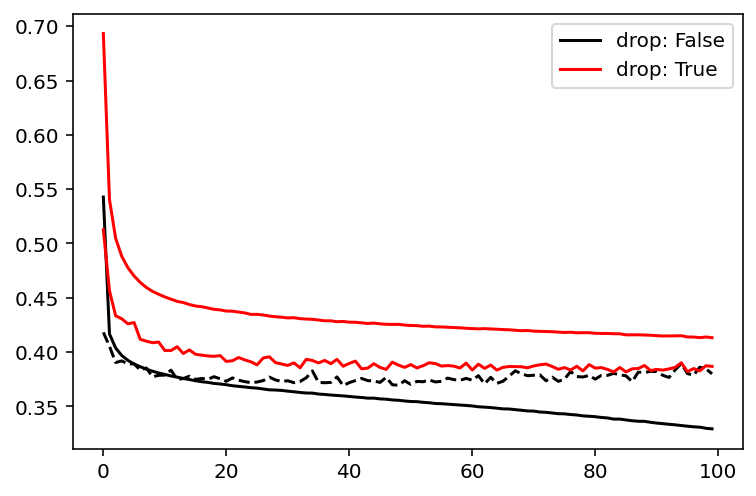

In [61]:
# get same models following first 16 params
filtered_df = df
for k, v in zip(df.iloc[min_i][:17].keys(), df.iloc[min_i][:17].values):
    filtered_df = filtered_df[filtered_df[k] == v]
    
#######

plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'root_mean_squared_error'])), color='k',
         label=f"drop: {filtered_df.iloc[0]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'val_root_mean_squared_error'])), '--k')

plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'root_mean_squared_error'])), color='r',
         label=f"drop: {filtered_df.iloc[1]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'val_root_mean_squared_error'])), 'r')

plt.legend()
filtered_df

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
0,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)",[],512,"[32, 64, 128, 128, 128, 128]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,True,"[0.5022448301315308, 0.3622158169746399, 0.315...","[0.6808104515075684, 0.5111223459243774, 0.464...","[0.4635028839111328, 0.2612460255622864, 0.216...","[0.5022448301315308, 0.3622158169746399, 0.315...","[0.30514031648635864, 0.27240654826164246, 0.2...","[0.4556020498275757, 0.42055872082710266, 0.41...","[0.20757323503494263, 0.17686964571475983, 0.1...","[0.30514031648635864, 0.27240654826164246, 0.2...","[1.3806566985594146, 1.2588919591843808, 1.313...",1.141013,"[1.3806566985594146, 1.2588919591843808, 1.313...",1.151217,"[1.5006757415831309, 1.6391040332931504, 1.702...",4.512691,"[1.5006757415831309, 1.6391040332931504, 1.702...",3.327699,"[1.2773098194627504, 1.2465013391943789, 1.286...",1.118213,"[1.2773098194627504, 1.2465013391943789, 1.286...",1.17442,"[1.5754778722019647, 1.612088918809939, 1.7009...",4.643323,"[1.5754778722019647, 1.612088918809939, 1.7009...",3.322503,"[1.5876472080601496, 1.6611661202437917, 1.783...",1.150549,"[1.5876472080601496, 1.6611661202437917, 1.783...",1.460479,"[1.750244760358427, 1.8203939347563836, 2.0450...",4.693368,"[1.750244760358427, 1.8203939347563836, 2.0450...",3.299503


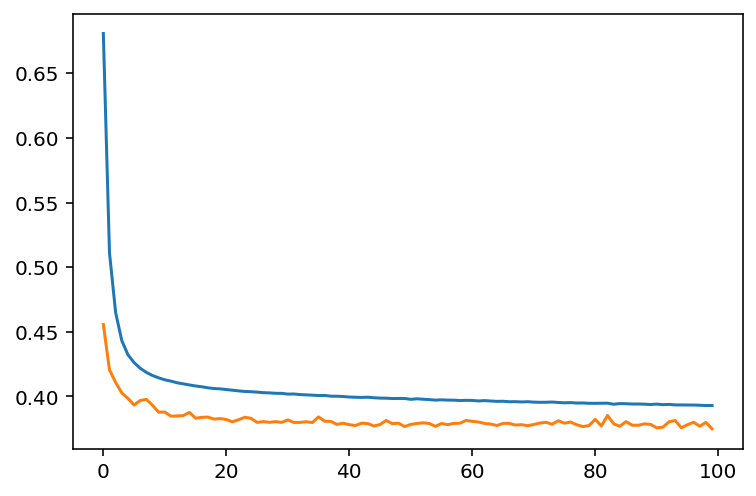

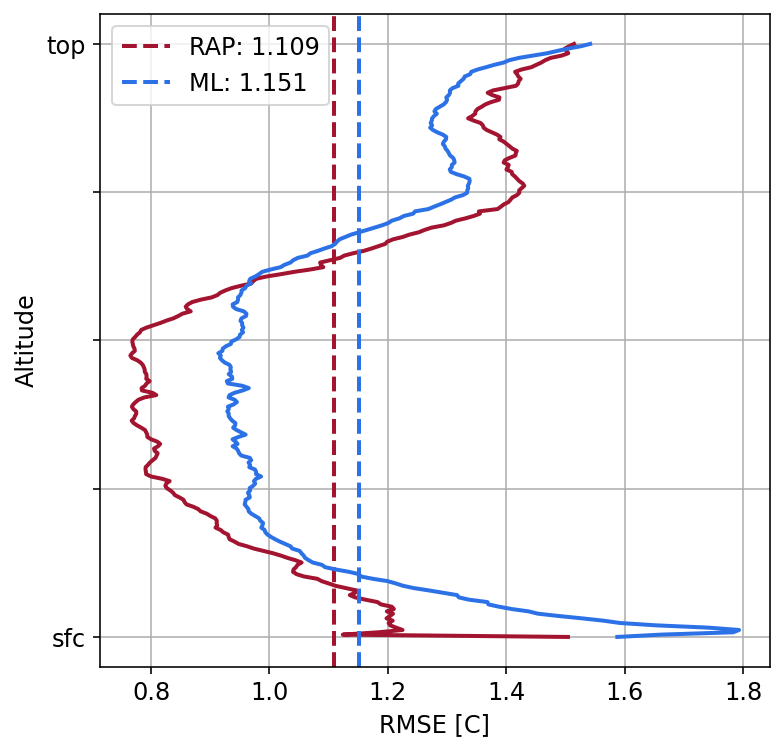

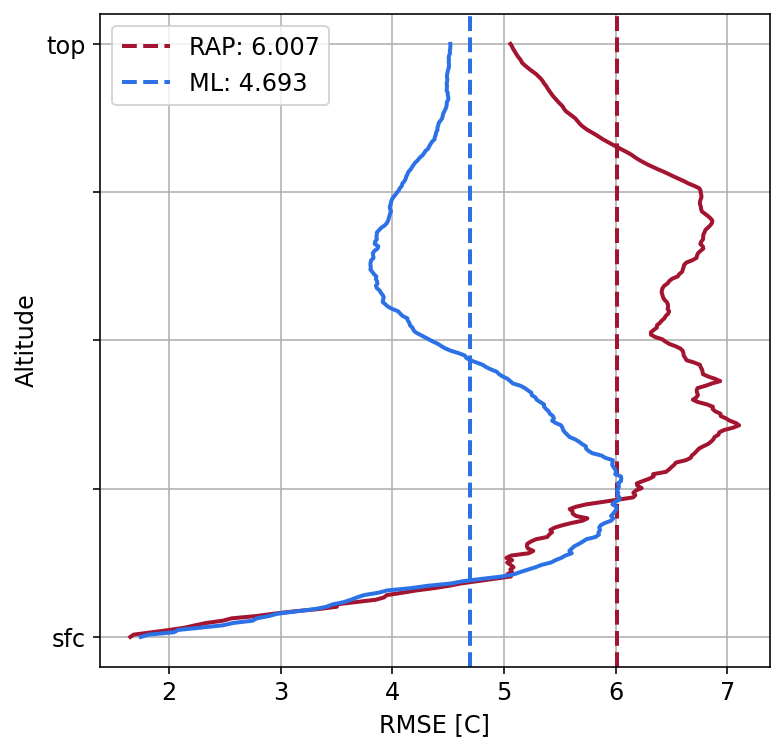

In [62]:
df = pd.read_csv(os.path.join(VOL, 'multi_cnn_model_temperature_dewpoint_regularization.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)
    
df.sort_values(['ml_temperature_test_mean_rmse']).head()

# Best Model

In [8]:
from soundings.experiments import multi_convolutional_neuralnetwork_driver as cnndriver
from soundings.deep_learning import tf_neuralnetwork as nn

In [9]:
data = (RAPtrain , RAPval,  RAPtest, 
        RTMAtrain, RTMAval, RTMAtest,
        GOEStrain, GOESval, GOEStest,
        RAOBtrain, RAOBval, RAOBtest)
rap_input_dims = [0, 1, 2, 3]
rap_output_dims = [1, 2]
rtma_input_channels = [0, 1, 2]
goes_input_channels = []

driver = cnndriver.MultiConvolutionalNeuralNetwork()

Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = driver.organize_data(data, rap_input_dims, rap_output_dims,
                                                                rtma_input_channels, goes_input_channels)

INFO: data organization - [0, 1, 2, 3] [1, 2] [0, 1, 2] []
INFO: data dimensions - (19007, 256, 4) (19007, 3, 3, 3) (19007, 512) (2535, 256, 4) (2535, 3, 3, 3) (2535, 512) (3798, 256, 4) (3798, 3, 3, 3) (3798, 512)


In [10]:
n_hiddens_list = []
n_units_in_conv_layers = [32, 64, 128, 256, 256]
kernels_size_and_stride = '(3, 1)'
rap_activation = 'relu'
dense_activation = 'relu'
optim = 'adam'
lr = 0.0001
loss = 'MAE'
n_epochs = 100
batch_size = 128
dropout = False
batchnorm = False

n_rap_inputs = Xtr.shape[1:] # (256, 4)
n_im_inputs  = Xti.shape[1:] if Xti is not None else None # (3, 3, 3)
n_network_outputs = Tt.shape[1]

nnet = nn.MultiConvolutionalNeuralNetwork(n_rap_inputs, n_im_inputs, n_hiddens_list, n_units_in_conv_layers,
                                                          [literal_eval(kernels_size_and_stride)]* \
                                                              len(n_units_in_conv_layers), # all same size
                                                          n_network_outputs, rap_activation=rap_activation,
                                                          dense_activation=dense_activation, 
                                                          batchnorm=batchnorm, dropout=dropout)
nnet.model.summary()
nnet.train(Xtr, Xti, Tt, n_epochs, batch_size, method=optim, verbose=False,
           learning_rate=lr, validation=(Xvr, Xvi, Tv), loss_f=loss)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 32)      416         rap[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 32)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 32)      0           activation[0][0]                 
_______________________________________________________________________________________

MultiConvolutionalNeuralNetwork(512)
  Final objective value is 0.22914 in 75.2779 seconds.

## Regional Errors

In [52]:
names_train = [f.split('_')[0] for f in FILEtrain]
names_val   = [f.split('_')[0] for f in FILEval]
names_test  = [f.split('_')[0] for f in FILEtest]

In [53]:
(np.unique(names_train, return_counts=True),
 np.unique(names_val, return_counts=True),
 np.unique(names_test, return_counts=True))

((array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
         'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
        dtype='<U3'),
  array([1093, 1054, 1047, 1048,  746, 1075, 1100, 1097, 1050, 1118, 1016,
         1088, 1047, 1056, 1125, 1114, 1060, 1073])),
 (array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
         'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
        dtype='<U3'),
  array([146, 141, 140, 140,  99, 143, 147, 146, 140, 149, 135, 145, 140,
         141, 150, 149, 141, 143])),
 (array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
         'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
        dtype='<U3'),
  array([218, 211, 209, 209, 149, 215, 219, 219, 210, 224, 203, 217, 209,
         211, 225, 223, 212, 215])))

In [47]:
locations = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df = pd.DataFrame.from_dict(locations).T
df = df.reset_index()
df.columns = ['location', 'lon', 'lat', 'indicies']
df.head(5)

,location,lon,lat,indicies
0,abr,-98.42,45.45,"[0, 15, 43, 56, 71, 91, 99, 104, 109, 175, 185..."
1,ilx,-89.33,40.15,"[1, 24, 47, 53, 59, 76, 115, 176, 184, 197, 22..."
2,unr,-103.21,44.07,"[2, 7, 9, 31, 33, 39, 66, 89, 94, 113, 116, 14..."
3,fwd,-97.3,32.8,"[3, 28, 40, 68, 69, 114, 133, 134, 137, 139, 1..."
4,maf,-102.2,31.93,"[4, 12, 19, 22, 65, 67, 111, 160, 193, 206, 23..."


In [6]:
t_rmse  = []
td_rmse = []
X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    T_loc = T[inds]
    Y_loc = Y[inds]
    t_rmse.append(ml.rmse(T_loc[:,:,1], Y_loc[:,:,0]))
    td_rmse.append(ml.rmse(T_loc[:,:,2], Y_loc[:,:,1]))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse

In [51]:
fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['lon'],
        lat = df['lat'],
        text = df['location'],
        mode = 'markers',
        marker = dict(
            size = 6,
            opacity = 0.80,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=0.80,
                color='rgba(75, 75, 75)'
            ),
            colorscale = 'ylorbr_r', # rdgy, viridis
            cmin = df['td_rmse'].min(), # 0,
            color = df['td_rmse'],
            cmax = df['td_rmse'].max(),
            colorbar_title='',
            colorbar = dict(
                nticks = 10,
                len = 0.90,
                thickness = 10,
                ticks = 'outside',
                tickcolor = 'black',
                tickfont = dict(family='Arial', size=11, color='black'), # "Courier New", "Times New Roman"
                x = 0.90
            ),
        )))


"""
['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
 'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
 'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
 'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
 'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
 'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
 'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
"""

fig.update_layout(
        geo = dict(
            scope = 'usa',
            projection_type = 'albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(100, 100, 100)",
            countrycolor = "rgb(100, 100, 100)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ), 
        margin=dict(l=0, r=0, t=0, b=5)
    )
fig.show()

fig.write_image('/home/stock/research/media/dewpoint_error_bubble_map.png', width=450, height=225, scale=4)

## Error Distribution by Month

In [15]:
from soundings.plotting import radiosonde_plotting

In [21]:
samples = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    month = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    if month in samples:
        arr = samples[month][0]
        arr.append(i)
        samples[month] = [arr]
    else:
        samples[month] = [[i]]
        
df = pd.DataFrame.from_dict(samples).T
df = df.reset_index()
df.columns = ['month', 'indicies']

df = df.sort_values('month')
df.head(5)

,month,indicies
7,1,"[30, 31, 36, 39, 47, 52, 58, 64, 69, 122, 128,..."
4,2,"[4, 7, 9, 19, 25, 28, 40, 50, 60, 80, 86, 88, ..."
1,3,"[1, 6, 10, 12, 24, 26, 27, 37, 51, 74, 79, 81,..."
2,4,"[2, 11, 17, 22, 29, 41, 44, 57, 77, 84, 85, 95..."
3,5,"[3, 8, 14, 21, 23, 33, 38, 42, 55, 62, 65, 71,..."


In [56]:
t_rmse  = []
td_rmse = []
X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    # sqrt of the mean difference between each vertical level (256,)
    t_rmse.append(np.sqrt(np.mean((T[inds,:,1] - Y[inds,:,0])**2, axis=0)))
    td_rmse.append(np.sqrt(np.mean((T[inds,:,2] - Y[inds,:,1])**2, axis=0)))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse

In [57]:
df.head()

,month,indicies,t_rmse,td_rmse
7,1,"[30, 31, 36, 39, 47, 52, 58, 64, 69, 122, 128,...","[1.2472209952264133, 1.2041853545634824, 1.304...","[1.2591615161878367, 1.3762696055504586, 1.504..."
4,2,"[4, 7, 9, 19, 25, 28, 40, 50, 60, 80, 86, 88, ...","[0.8447774498663903, 1.0975332786221799, 1.211...","[1.0393812971232477, 1.6601007378880253, 1.877..."
1,3,"[1, 6, 10, 12, 24, 26, 27, 37, 51, 74, 79, 81,...","[0.8971007756545156, 1.028003383449972, 1.1155...","[1.776474226805341, 1.481115176989874, 1.62803..."
2,4,"[2, 11, 17, 22, 29, 41, 44, 57, 77, 84, 85, 95...","[0.8299682842679028, 1.0005640942476788, 1.067...","[0.976561179889159, 1.3628917531081681, 1.6082..."
3,5,"[3, 8, 14, 21, 23, 33, 38, 42, 55, 62, 65, 71,...","[0.7817479826386142, 0.907991859613969, 1.0160...","[0.9515574047372465, 1.3318920012137494, 1.523..."


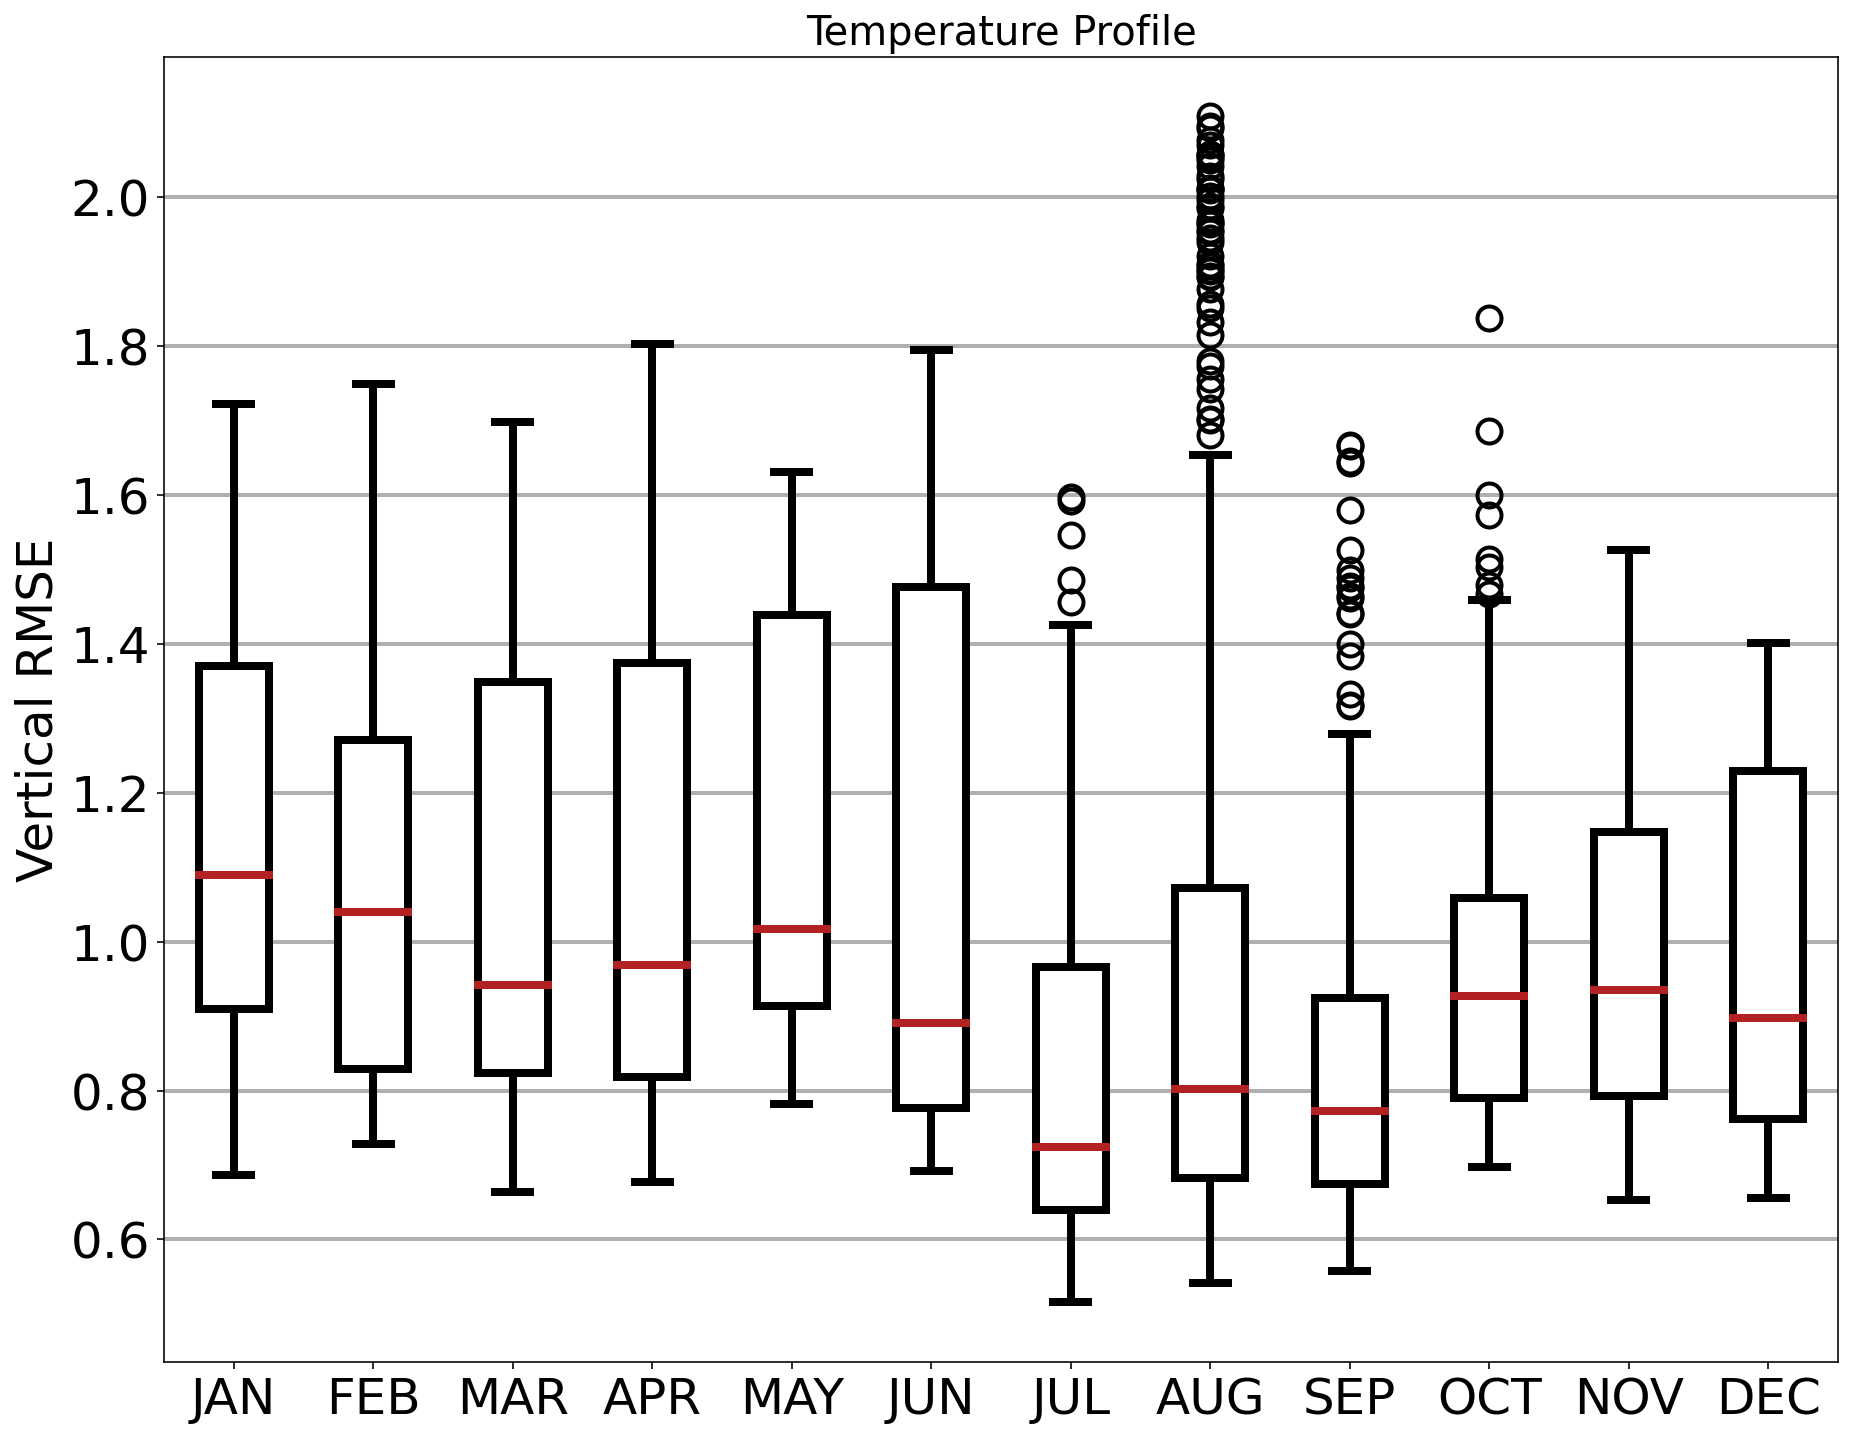

In [63]:
radiosonde_plotting.plot_monthly_error(df['t_rmse'].values, df['month'].values, 'Temperature Profile', 
                                       file_name='/home/stock/research/media/temperature_monthly_error.png');

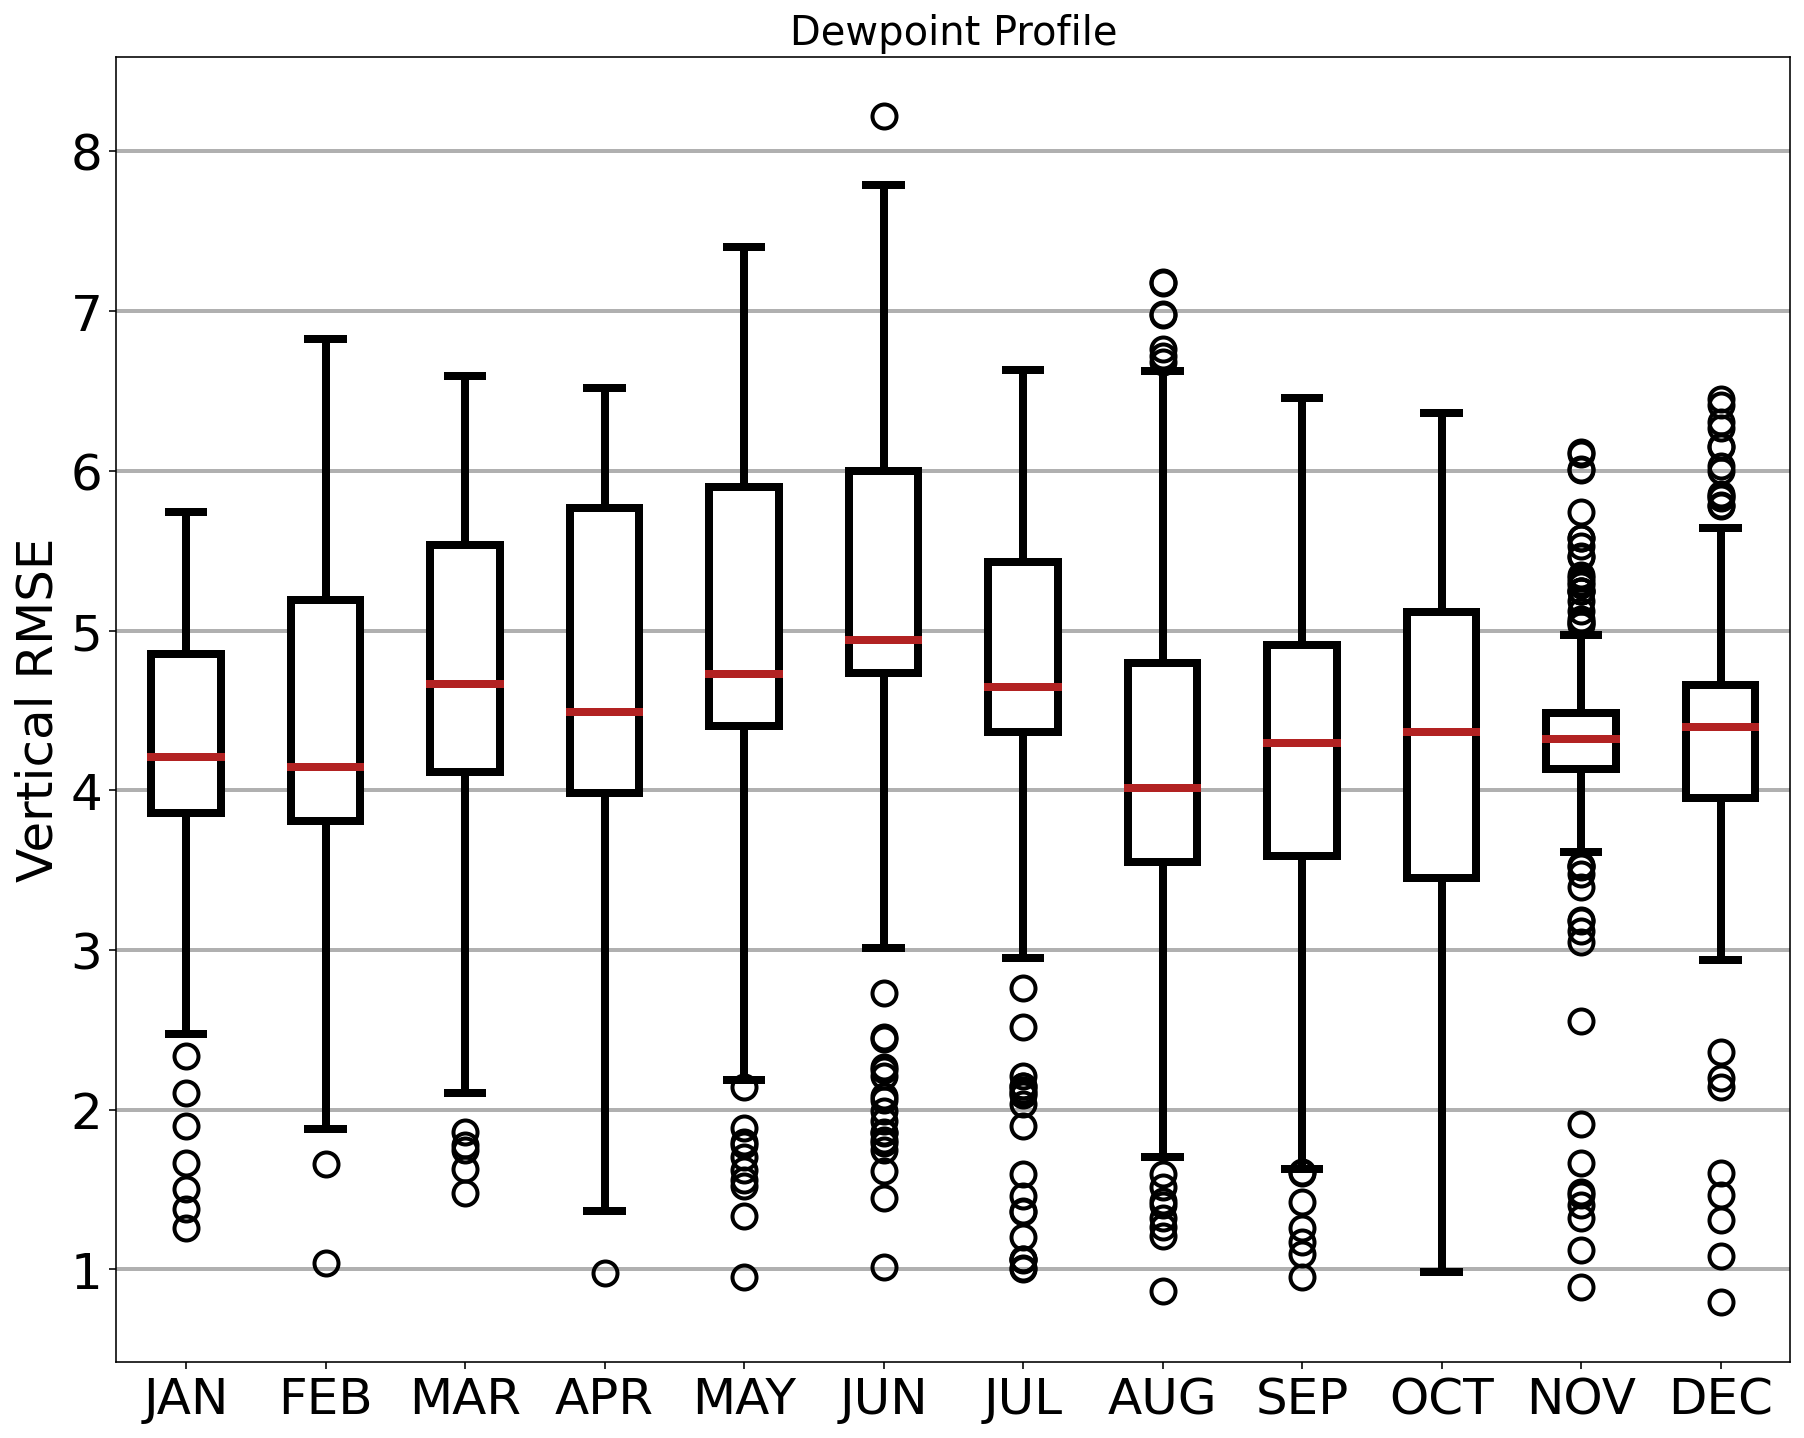

In [64]:
radiosonde_plotting.plot_monthly_error(df['td_rmse'].values, df['month'].values, 'Dewpoint Profile',
                                       file_name='/home/stock/research/media/dewpoint_monthly_error.png');